In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from scipy.ndimage import median_filter
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20 #width x height in inches
# Load the 3D model
tumor_3d_model = tf.keras.models.load_model(r"C:\Users\kaczm\programming\3DRDNN\models\new_yt_3D_lesion\03-0.4084.hdf5")


# let's start with normal image and make some predictions

import SimpleITK as sitk
import glob
from tqdm import tqdm


def preprocessing_3d(t1) -> np.ndarray:
    min = 50
    max = 200
    t1 = np.where(t1 < min, min, t1)
    t1 = np.where(t1 > max, max, t1)
    t1 -= min
    return t1 / (max-min)


def label_seperator_liver(img):
    img = np.where(img == 2, 1, img)
    return img


def label_seperator_lesion(img):
    img = np.where(img == 1, 0, img)
    img = np.where(img == 2, 1, img)
    return img


def reading_data(path: str) -> np.ndarray:
    sitk_t1 = sitk.ReadImage(path)
    t1 = sitk.GetArrayFromImage(sitk_t1)
    t1 = t1.reshape(t1.shape[0], t1.shape[1], t1.shape[2], 1)

    t1 = tf.dtypes.cast(t1, tf.float32)

    return t1

def label_seperator_liver(img):
        img = np.where(img == 2, 1, img)
        return img

def z_transform(img_volume, img_seg, param_z=256):
        return_img_volume = np.zeros(
            (param_z, img_volume.shape[1], img_volume.shape[2], img_volume.shape[3])
        )
        return_img_seg = np.zeros(
            (param_z, img_seg.shape[1], img_seg.shape[2], img_seg.shape[3])
        )
        for i in range(img_seg.shape[1]):
            return_img_volume[:, i, :, 0:1] = tf.image.resize(
                img_volume[:, i, :, 0:1], [param_z, 512])
            return_img_seg[:, i, :, 0:1] = tf.image.resize(
                img_seg[:, i, :, 0:1],
                [param_z, 512],
                method="nearest",
            )
        return return_img_volume, return_img_seg


path = "data\\LITS_Challenge\\test\\"
files_volume = glob.glob(path + "\\volume*.nii")
files_segmenation = glob.glob(path + "\\segmentation*.nii")



In [2]:
# for one file

no_of_file_to_process = 0
volume = reading_data(files_volume[no_of_file_to_process])
gt = reading_data(files_segmenation[no_of_file_to_process])
volume = preprocessing_3d(volume)


In [24]:
result_3d = np.zeros((volume.shape))
z, x, y = (438, 250, 200)  # starting point

batch_size = 32


# what to do? get all slices around liver for each patient.


# this produce patches
def patch_generator(volume,gt):

    # find min / max of liver cords.
    liver_z, liver_x, liver_y, _ = np.where(gt == 2)
    x_min, x_max = np.min(liver_x), np.max(liver_x)
    y_min, y_max = np.min(liver_y), np.max(liver_y)
    z_min, z_max = np.min(liver_z), np.max(liver_z)

    qube_step_size = 8

    arr_1 = np.arange(z_min - qube_step_size,z_max + qube_step_size,qube_step_size)
    arr_2 = np.arange(x_min - qube_step_size,x_max + qube_step_size,qube_step_size)
    arr_3 = np.arange(y_min - qube_step_size,y_max + qube_step_size,qube_step_size)



    for shift in tqdm(arr_1):
        for shift_2 in arr_2:
            for shift_3 in arr_3:
                
                one_qube = volume[
                    shift - 16 : shift + 16,
                    shift_2 - 16 : shift_2 + 16,
                    shift_3 - 16 : shift_3 + 16,
                ]

                one_qube = np.where(gt[
                   shift - 16 : shift + 16,
                    shift_2 - 16 : shift_2 + 16,
                    shift_3 - 16 : shift_3 + 16,
                ] > 0, one_qube, 0)

                try:
                    yield one_qube.reshape(1, 32, 32, 32, 1), [shift,shift_2,shift_3]
                except ValueError:
                    continue



cond = True
            
patches = patch_generator(volume,gt)
###### predict
try:
    while cond:
        batch = np.zeros((batch_size,32,32,32,1))

        batch_shifts = []
        for b in range(batch_size):
            batch[b,:,:,:,0:1], shifts = next(patches)
            batch_shifts.append(shifts)

        pred_3d = tumor_3d_model.predict(batch, verbose=0)
        for b in range(batch_size):
            shifts = batch_shifts[b]

            pred_3d[b] = np.where(gt[
            shifts[0] - 16 : shifts[0] + 16,
            shifts[1] - 16 : shifts[1] + 16,
            shifts[2] - 16 : shifts[2] + 16,
            ] > 0, pred_3d[b], 0)


            result_3d[
            shifts[0] - 16 : shifts[0] + 16,
            shifts[1] - 16 : shifts[1] + 16,
            shifts[2] - 16 : shifts[2] + 16,
        ] += pred_3d[b]

        
except StopIteration:
    print("stopped")



157 357 82 327 388 524
(19,) (27,) (33,)
[380 388 396 404 412 420 428 436 444 452 460 468 476 484 492 500 508 516
 524] [149 157 165 173 181 189 197 205 213 221 229 237 245 253 261 269 277 285
 293 301 309 317 325 333 341 349 357] [ 74  82  90  98 106 114 122 130 138 146 154 162 170 178 186 194 202 210
 218 226 234 242 250 258 266 274 282 290 298 306 314 322 330]


100%|██████████| 19/19 [01:49<00:00,  5.75s/it]

stopped


In [25]:
print(result_3d.shape)
result_3d = median_filter(result_3d, footprint= np.ones((1,10,10,1)))

(816, 512, 512, 1)


In [26]:
# binarization

binary_result_3d = np.where(result_3d >4, 1, 0)

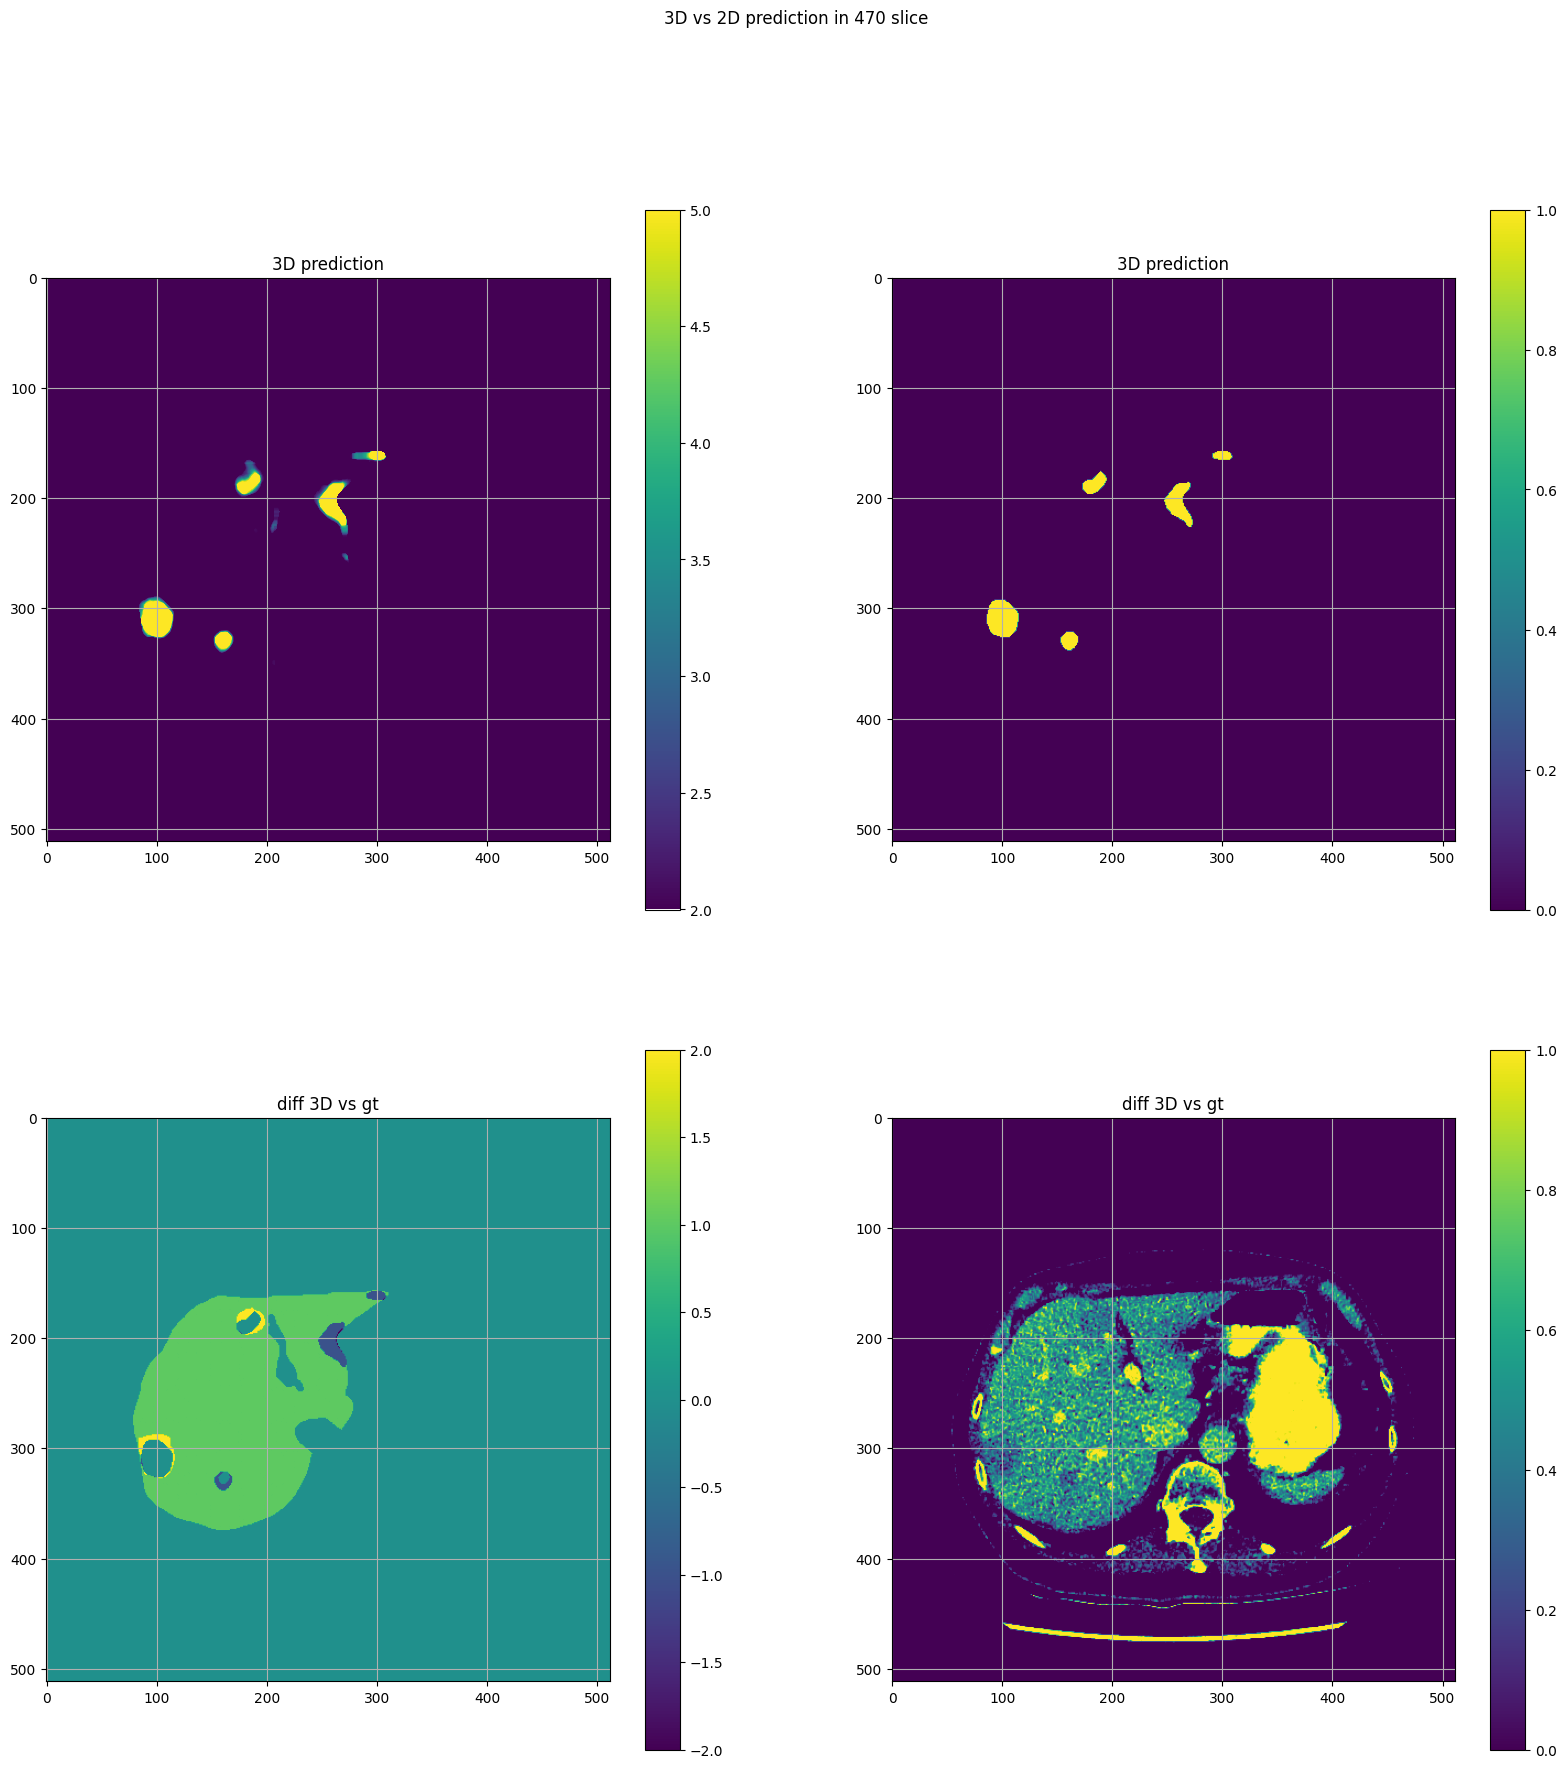

In [27]:
s=470
#for s in tqdm(range(350,550,1)):


plt.suptitle(f"3D vs 2D prediction in {s} slice")
plt.subplot(2,2,1)
plt.title("3D prediction")
plt.imshow(result_3d[s],vmin=2,vmax=5)
plt.colorbar()
plt.grid()


plt.subplot(2,2,2)
plt.title("3D binarized prediction")
plt.imshow(binary_result_3d[s],vmin=0,vmax=1)
plt.colorbar()
plt.grid()



plt.subplot(2,2,3)
plt.title("diff 3D vs gt")
plt.imshow(gt[s]-2*binary_result_3d[s],vmin=-2,vmax=2)
plt.colorbar()
plt.grid()

plt.subplot(2,2,4)
plt.title("volume")
plt.imshow(volume[s])
plt.colorbar()
plt.grid()


In [28]:
gt_lessions = np.where(gt == 2, 1,0)

binary_result_3d = np.where(result_3d > 5, 1, 0)


precision_3D = tf.keras.metrics.Precision(thresholds=0.5)
recall_3D = tf.keras.metrics.Recall(thresholds=0.5)

precision_3D.update_state(gt_lessions, binary_result_3d)
recall_3D.update_state(gt_lessions, binary_result_3d)

print("precision: ", precision_3D.result().numpy())
print("recall: ", recall_3D.result().numpy())

precision:  0.72586167
recall:  0.7345144
